<a href="https://colab.research.google.com/github/g-roger/analise-vegetativa-bemagro/blob/main/Oficial_20ia_05_EDA_bemagro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analise de vegetação

Neste projeto possui dois datasets com imagens de setores de uma fazenda da região do Mato Grosso do Sul. O objetivo é baseado nas mesmas, responder as seguintes questões:

1. Baseado na análise das imagens, podemos avaliar se a lavoura está adiantada ou atrasada?
2. Existem áreas de recorrência do subdesenvolvimento? É possível detectar essas áreas?
3. Existem áreas de subdesenvolvimento exclusivos de uma determinada cultura?

Além dos datasets, foram fornecidos arquivos CSV. Eles listam algumas variáveis sobre as imagens que estão nos datasets.

Os pontos que serão estudados nesse notebook tem como base resolver as questões acima, possivelmente com o uso de ferramentas de visão computacional, machine learning e/ou deep learning.

## Imagens do dataset

As diferenças entre ambos os datasets aparentemente são as localizações. 

As imagens possuem em seu label sua data, podendo realizar uma análise temporal para entender as diferenças e apontar algum estudo que resolva alguma das questões acima.

### Formato das imagens

Ambos os datasets possuem dois diretórios, um chamado RGB e outro NDVI.

RGB é uma escala que possuí três canais(bands) de cores, cujo são: Red, Green e Blue. Comparar as imagens com histogramas nessa escala tende a ser mais efetivo para detectar recorrencia de áreas de subdesenvolvimento.

NDVI é uma imagem que foi cálculada o índice de vegetação, o mesmo é possível análisar a vegetação da localidade e entender melhor sua cultura e monitorar sua lavoura.

A fórmula e como segue:      NDVI = (Infra Vermelho – Vermelho) / (Infra Vermelho +Vermelho)

O princípio teórico é que a vegetação, quanto mais ativa, mais absorve a luz solar na região do vermelho, no processo de trabalho da clorofila nos tecidos vegetais, deixando os valores digitais baixos da imagem de satélite no canal vermelho. Da mesma forma, a estruturas celulares das folhas provocam uma forte reflexão da luz solar na região do  Infravermelho próximo (distribuição angular delas e o fator de reflectância bidirecional e outros fatores externos, explica a literatura), deixando os valores digitais altos da imagem de satélite no canal infra vermelho. (texto retirado de: http://www.engesat.com.br/softwares/global-mapper/calculo-do-indice-de-vegetacao-ndvi-no-global-mapper/#:~:text=NDVI%20%C3%A9%20a%20abrevia%C3%A7%C3%A3o%20da,imagens%20geradas%20por%20sensores%20remotos.)

## Pretenções do projeto

Foram refletidos alguns pontos para resolução das questões:

- Analise sobre volumetria de culturas;
- Analise exploratória sobre NDVI para entendimento se lavoura está adiantada ou atrasada;
- Analise exploratória sobre RGB para entendimento se possuí áreas de subdesenvolvimento (NDVI)
- Clusterização de grupos de imagens por pixels para saber se estão em área de subdesenvolvimento ou não;

Ideias que foram pensadas:

 - Explorar conectar google earth com dados de chuvas/temporais da região listada e saber se tem interferências em áreas de subdesenvolvimento;
 - Regressão linear para entender se determinada área é produtiva ou não

## Objetivos

Parte desse dateset são estudos que levam a responder e criar questões sobre as imagens de satélites disponibilizadas, outra parte traz uma possível solução que foi pensada em primeiramente entender como é organizado o dataset, entender e estudar as imagens NDVI's, Segmentar as imagens e entender seus índices, realizar a classificação e após isso extrair uma média dos pixels do contorno obtidas através de bibliotecas de estudo. No final do processo queremos analizar uma porcentagem de produtividade de cada imagem e compara-las.
O que é produtivo, o que não é produtivo e o que é nuvem.

# Instalações obrigatórias

In [1]:
# requirements

!pip install rasterio
!pip install ipygee
!pip install geemap

# Importações

In [2]:
# raster imports e básico para análise
import pandas as pd
import rasterio
from rasterio.plot import show, show_hist
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import rasterio.features
import rasterio.warp
from ipygee import*
rasterio.__version__

'1.2.10'

# Leitura de datasets

In [3]:
# paths

path = 'https://raw.githubusercontent.com/g-roger/analise-vegetativa-bemagro/main/datasets'
dataset_1 = path + '/dataset_1/'
dataset_2 = path + '/dataset_2/'
df_1 = pd.read_csv(dataset_1 + 'DATASET1.csv')
df_2 = pd.read_csv(dataset_2 + 'DATASET2.csv')

In [4]:
df_1.sort_values(by='Nublado', ascending=False)

temp ano  temp mes        Data Nublado   Cultura                 RGB  \
7       2017         1  2017-01-04   9,52%  colheita  RGB/2017-01-04.tif   
16      2017        11  2017-11-15   6,93%      soja  RGB/2017-11-15.tif   
29      2018        12  2018-12-25   6,34%  colheita  RGB/2018-12-25.tif   
44      2020         3  2020-03-19   6,04%   algodao  RGB/2020-03-19.tif   
9       2017         4  2017-04-04  56,00%   algodao  RGB/2017-04-04.tif   
..       ...       ...         ...     ...       ...                 ...   
21      2018         4  2018-04-14   0,00%   algodao  RGB/2018-04-14.tif   
22      2018         5  2018-05-14   0,00%   algodao  RGB/2018-05-14.tif   
23      2018         6  2018-06-18   0,00%   algodao  RGB/2018-06-18.tif   
34      2019         5  2019-05-19   0,00%   algodao  RGB/2019-05-19.tif   
0       2016         3  2016-03-30   0,00%   algodao  RGB/2016-03-30.tif   

                   NDVI  
7   NDVI/2017-01-04.tif  
16  NDVI/2017-11-15.tif  
29  NDVI/2018-12-25.tif  
44  NDVI/2020-03-19.tif  
9   NDVI/2017-04-04.tif  
..                  ...  
21  NDVI/2018-04-14.tif  
22  NDVI/2018-05-14.tif  
23  NDVI/2018-06-18.tif  
34  NDVI/2019-05-19.tif  
0   NDVI/2016-03-30.tif  

[66 rows x 7 columns]

In [5]:
df_1.head(20)

temp ano  temp mes        Data Nublado   Cultura                 RGB  \
0       2016         3  2016-03-30   0,00%   algodao  RGB/2016-03-30.tif   
1       2016         4  2016-04-29   0,00%   algodao  RGB/2016-04-29.tif   
2       2016         7  2016-07-18   0,00%   algodao  RGB/2016-07-18.tif   
3       2016         8  2016-08-07   0,00%  colheita  RGB/2016-08-07.tif   
4       2016         9  2016-09-16   0,89%      soja  RGB/2016-09-16.tif   
5       2016        11  2016-11-25  13,24%      soja  RGB/2016-11-25.tif   
6       2016        12  2016-12-05  22,73%      soja  RGB/2016-12-05.tif   
7       2017         1  2017-01-04   9,52%  colheita  RGB/2017-01-04.tif   
8       2017         2  2017-02-23  13,08%   algodao  RGB/2017-02-23.tif   
9       2017         4  2017-04-04  56,00%   algodao  RGB/2017-04-04.tif   
10      2017         5  2017-05-14   0,00%   algodao  RGB/2017-05-14.tif   
11      2017         6  2017-06-03   0,00%   algodao  RGB/2017-06-03.tif   
12      2017         7  2017-07-13   0,00%   algodao  RGB/2017-07-13.tif   
13      2017         8  2017-08-17   0,00%  colheita  RGB/2017-08-17.tif   
14      2017         9  2017-09-11   0,00%      soja  RGB/2017-09-11.tif   
15      2017        10  2017-10-16   0,00%      soja  RGB/2017-10-16.tif   
16      2017        11  2017-11-15   6,93%      soja  RGB/2017-11-15.tif   
17      2017        12  2017-12-20   0,00%      soja  RGB/2017-12-20.tif   
18      2018         1  2018-01-24  53,29%  colheita  RGB/2018-01-24.tif   
19      2018         2  2018-02-18   0,00%   algodao  RGB/2018-02-18.tif   

                   NDVI  
0   NDVI/2016-03-30.tif  
1   NDVI/2016-04-29.tif  
2   NDVI/2016-07-18.tif  
3   NDVI/2016-08-07.tif  
4   NDVI/2016-09-16.tif  
5   NDVI/2016-11-25.tif  
6   NDVI/2016-12-05.tif  
7   NDVI/2017-01-04.tif  
8   NDVI/2017-02-23.tif  
9   NDVI/2017-04-04.tif  
10  NDVI/2017-05-14.tif  
11  NDVI/2017-06-03.tif  
12  NDVI/2017-07-13.tif  
13  NDVI/2017-08-17.tif  
14  NDVI/2017-09-11.tif  
15  NDVI/2017-10-16.tif  
16  NDVI/2017-11-15.tif  
17  NDVI/2017-12-20.tif  
18  NDVI/2018-01-24.tif  
19  NDVI/2018-02-18.tif

In [6]:
df_2

temp ano  temp mes        Data Nublado   Cultura                 RGB  \
0       2016         3  2016-03-30   0,00%   algodao  RGB/2016-03-30.tif   
1       2016         4  2016-04-29   0,00%   algodao  RGB/2016-04-29.tif   
2       2016         5  2016-05-19   0,00%   algodao  RGB/2016-05-19.tif   
3       2016         6  2016-06-28   0,00%   algodao  RGB/2016-06-28.tif   
4       2016         7  2016-07-18   0,00%  colheita  RGB/2016-07-18.tif   
..       ...       ...         ...     ...       ...                 ...   
62      2021         8  2021-08-11   0,00%   algodao  RGB/2021-08-11.tif   
63      2021         9  2021-09-15   0,00%  colheita  RGB/2021-09-15.tif   
64      2021        10  2021-10-15   0,00%      soja  RGB/2021-10-15.tif   
65      2021        11  2021-11-29   0,00%      soja  RGB/2021-11-29.tif   
66      2021        12  2021-12-04   0,00%      soja  RGB/2021-12-04.tif   

                   NDVI  
0   NDVI/2016-03-30.tif  
1   NDVI/2016-04-29.tif  
2   NDVI/2016-05-19.tif  
3   NDVI/2016-06-28.tif  
4   NDVI/2016-07-18.tif  
..                  ...  
62  NDVI/2021-08-11.tif  
63  NDVI/2021-09-15.tif  
64  NDVI/2021-10-15.tif  
65  NDVI/2021-11-29.tif  
66  NDVI/2021-12-04.tif  

[67 rows x 7 columns]

In [7]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   temp ano  66 non-null     int64 
 1   temp mes  66 non-null     int64 
 2   Data      66 non-null     object
 3   Nublado   66 non-null     object
 4   Cultura   66 non-null     object
 5   RGB       66 non-null     object
 6   NDVI      66 non-null     object
dtypes: int64(2), object(5)
memory usage: 3.7+ KB


#Analise sobre volumetria de culturas

In [8]:
# contagem de imagens de cada uma das culturas:

print(df_1.Cultura.value_counts(),'\n')
print(df_2.Cultura.value_counts())

algodao     34
soja        21
colheita    11
Name: Cultura, dtype: int64 

algodao     35
soja        21
colheita    11
Name: Cultura, dtype: int64


In [9]:
df_1_culturas = df_1.groupby('Cultura').size().reset_index().sort_values(0, ascending=False)
df_2_culturas = df_2.groupby('Cultura').size().reset_index().sort_values(0, ascending=False)
df_1_culturas.head()

Cultura   0
0   algodao  34
2      soja  21
1  colheita  11

In [10]:
df_2_culturas

Cultura   0
0   algodao  35
2      soja  21
1  colheita  11

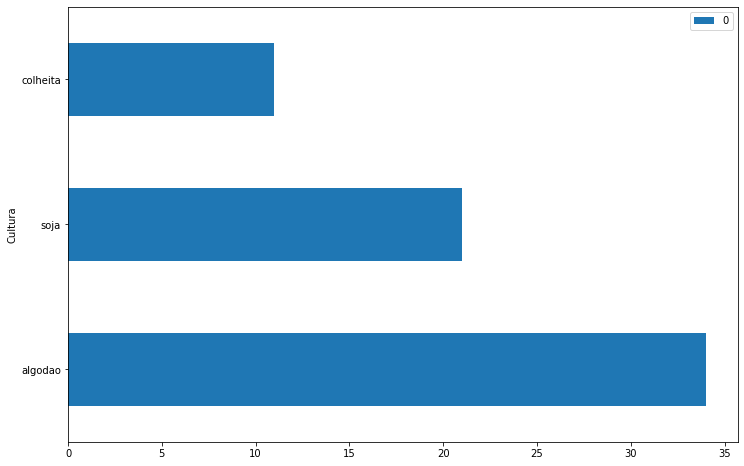

In [11]:
df_1_culturas.plot.barh(x='Cultura', y=0, figsize=(12,8))

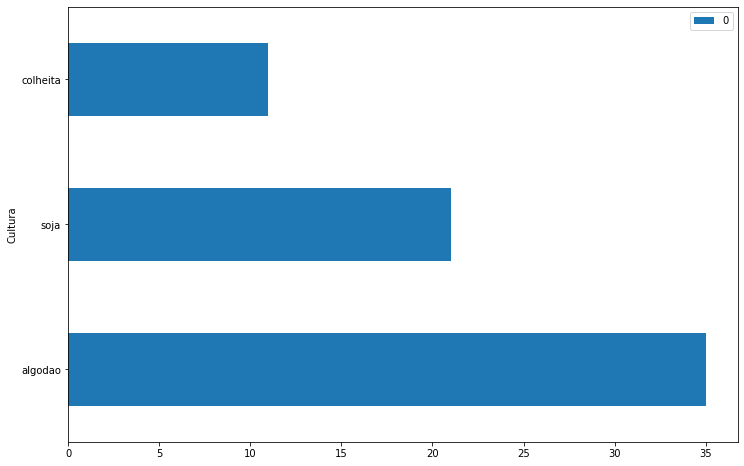

In [12]:
df_2_culturas.plot.barh(x='Cultura', y=0, figsize=(12,8))

- Ambos os datasets possuem aproximadamente a mesma quantidade de culturas;
- Levando em consideração que cada uma das imagens tem sua data, o tempo a quantidade de plantação de algodão é maior enquanto soja é menor. A colheita é representada 11 vezes em ambos datasets;
- Um ponto que podemos levar em consideração em relação a se uma cultura pode se desenvolver mais no resultado do estudo pode ter um viés para o lado do algodão por ser o que tem mais insumos para estudo

# Exploração NDVI

for # Analise exploratória sobre NDVI para entendimento se lavoura está adiantada ou atrasada

In [13]:
df_1.head(11)

temp ano  temp mes        Data Nublado   Cultura                 RGB  \
0       2016         3  2016-03-30   0,00%   algodao  RGB/2016-03-30.tif   
1       2016         4  2016-04-29   0,00%   algodao  RGB/2016-04-29.tif   
2       2016         7  2016-07-18   0,00%   algodao  RGB/2016-07-18.tif   
3       2016         8  2016-08-07   0,00%  colheita  RGB/2016-08-07.tif   
4       2016         9  2016-09-16   0,89%      soja  RGB/2016-09-16.tif   
5       2016        11  2016-11-25  13,24%      soja  RGB/2016-11-25.tif   
6       2016        12  2016-12-05  22,73%      soja  RGB/2016-12-05.tif   
7       2017         1  2017-01-04   9,52%  colheita  RGB/2017-01-04.tif   
8       2017         2  2017-02-23  13,08%   algodao  RGB/2017-02-23.tif   
9       2017         4  2017-04-04  56,00%   algodao  RGB/2017-04-04.tif   
10      2017         5  2017-05-14   0,00%   algodao  RGB/2017-05-14.tif   

                   NDVI  
0   NDVI/2016-03-30.tif  
1   NDVI/2016-04-29.tif  
2   NDVI/2016-07-18.tif  
3   NDVI/2016-08-07.tif  
4   NDVI/2016-09-16.tif  
5   NDVI/2016-11-25.tif  
6   NDVI/2016-12-05.tif  
7   NDVI/2017-01-04.tif  
8   NDVI/2017-02-23.tif  
9   NDVI/2017-04-04.tif  
10  NDVI/2017-05-14.tif

In [14]:
# definindo mapa de cores de índice

mymap = mpl.colors.LinearSegmentedColormap.from_list('mycolors',['red','green'])

sm = plt.cm.ScalarMappable(cmap=mymap)


In [15]:
ndvi_images = []

for i in range(0, 7):
  ndvi_images.append(rasterio.open(dataset_1 + df_1['NDVI'][i]))

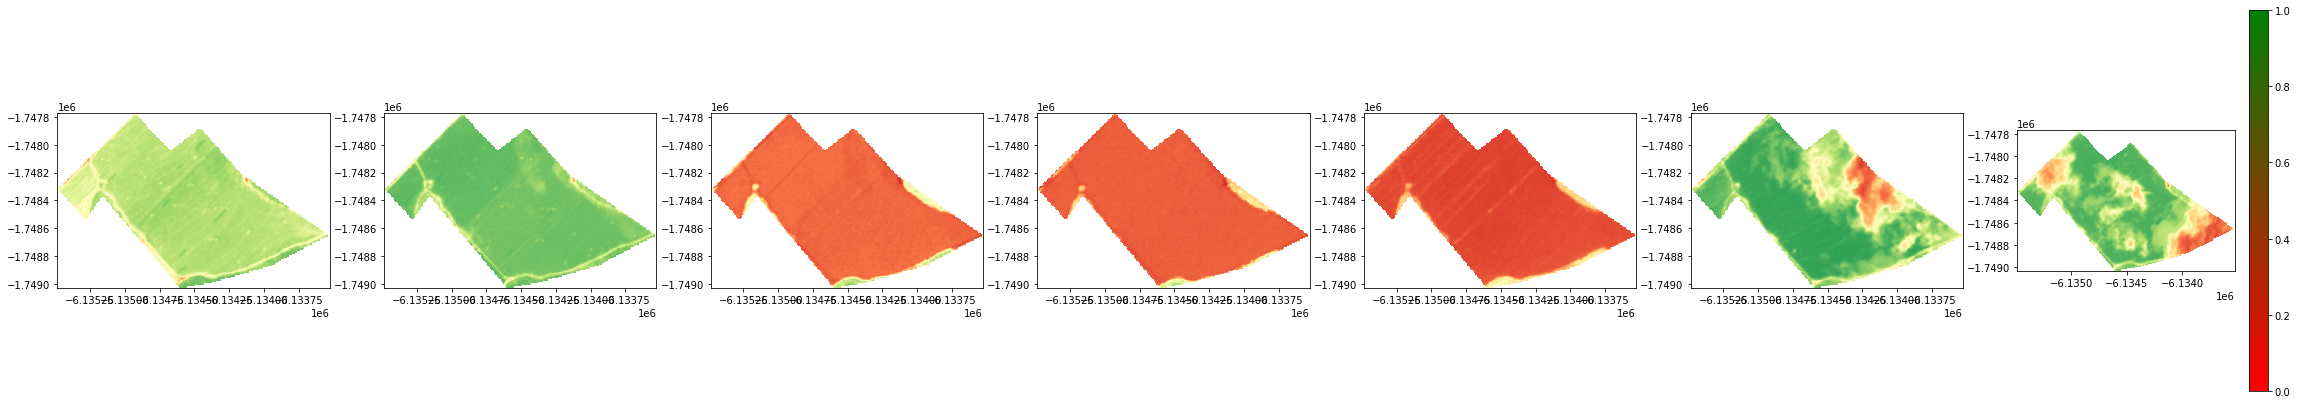

In [16]:

fig, axes = plt.subplots(1, len(ndvi_images), figsize=(40,7))
for ax, ndvi in zip(axes.flat, ndvi_images):
    show(ndvi, ax=ax, cmap='RdYlGn', vmin=0, vmax=1)

plt.colorbar(sm)
plt.show()

- Observamos que quanto mais vermelha a imagem, mais próxima da colheita.. é um ponto sobre a lavoura estar adiantada?

- será que é caracteristica da cultura "soja" demorar a imagem ficar vermelha. Ou é um indício de atraso da lavoura


In [17]:
df_1.head(7)

temp ano  temp mes        Data Nublado   Cultura                 RGB  \
0      2016         3  2016-03-30   0,00%   algodao  RGB/2016-03-30.tif   
1      2016         4  2016-04-29   0,00%   algodao  RGB/2016-04-29.tif   
2      2016         7  2016-07-18   0,00%   algodao  RGB/2016-07-18.tif   
3      2016         8  2016-08-07   0,00%  colheita  RGB/2016-08-07.tif   
4      2016         9  2016-09-16   0,89%      soja  RGB/2016-09-16.tif   
5      2016        11  2016-11-25  13,24%      soja  RGB/2016-11-25.tif   
6      2016        12  2016-12-05  22,73%      soja  RGB/2016-12-05.tif   

                  NDVI  
0  NDVI/2016-03-30.tif  
1  NDVI/2016-04-29.tif  
2  NDVI/2016-07-18.tif  
3  NDVI/2016-08-07.tif  
4  NDVI/2016-09-16.tif  
5  NDVI/2016-11-25.tif  
6  NDVI/2016-12-05.tif

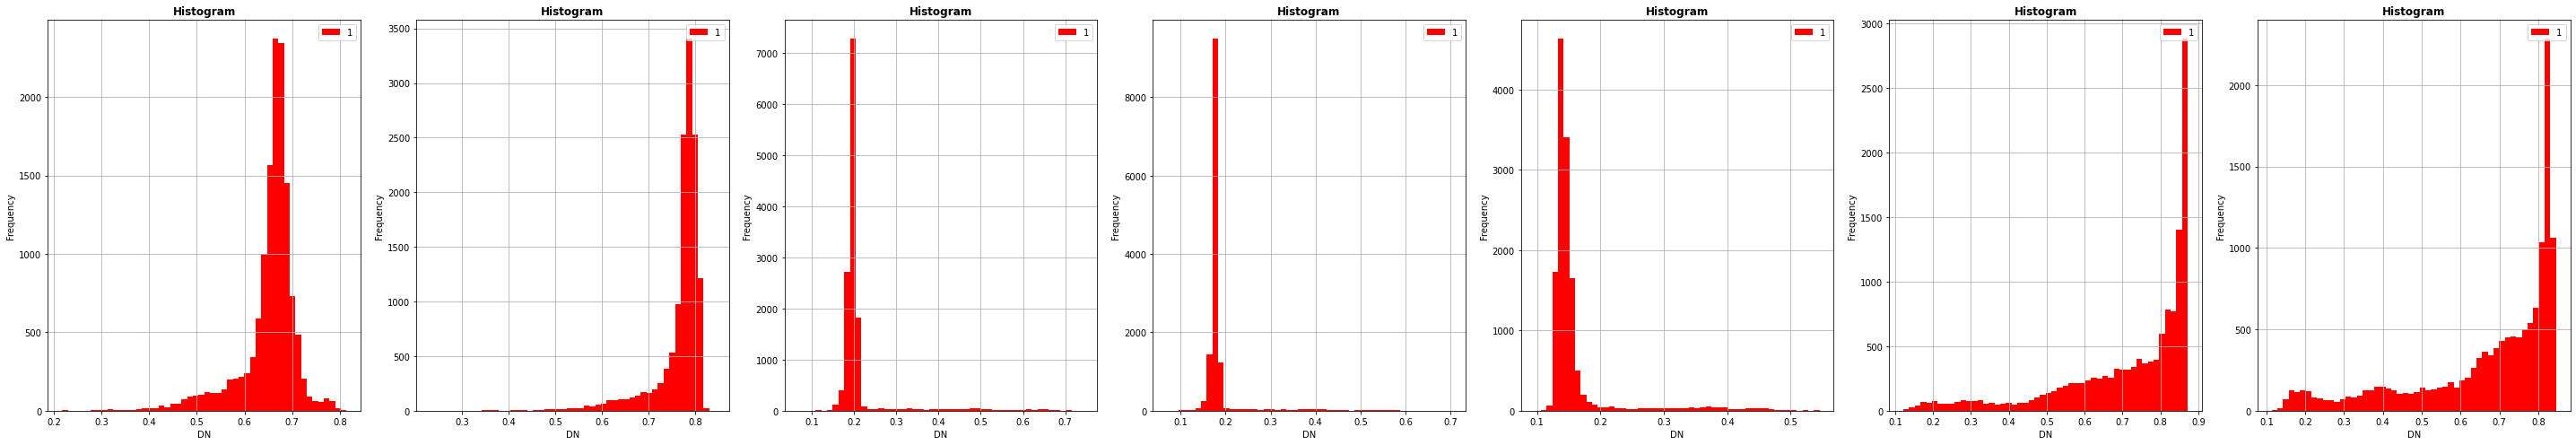

In [18]:

fig, axes = plt.subplots(1, len(ndvi_images), figsize=(40,7))
for ax, ndvi in zip(axes.flat, ndvi_images):
  show_hist(ndvi, ax=ax, bins=50, stacked=False, histtype='stepfilled', title="Histogram")

fig.tight_layout()

Considerando olhares do grupo e dos professores que nos orientaram, entendemos que essa lavoura observando alguns NDVI's aparentemente segue um passo normal, com algumas regiões adiantadas e outras atrasadas, os histogramas nos indicam quando uma região pode estar próxima da colheita ou não.

# Analise exploratória sobre RGB para entendimento se possuí áreas de subdesenvolvimento

In [19]:
rgb_images = []

for i in range(0, 7):
  rgb_images.append(rasterio.open(dataset_1 + df_1['RGB'][i]))

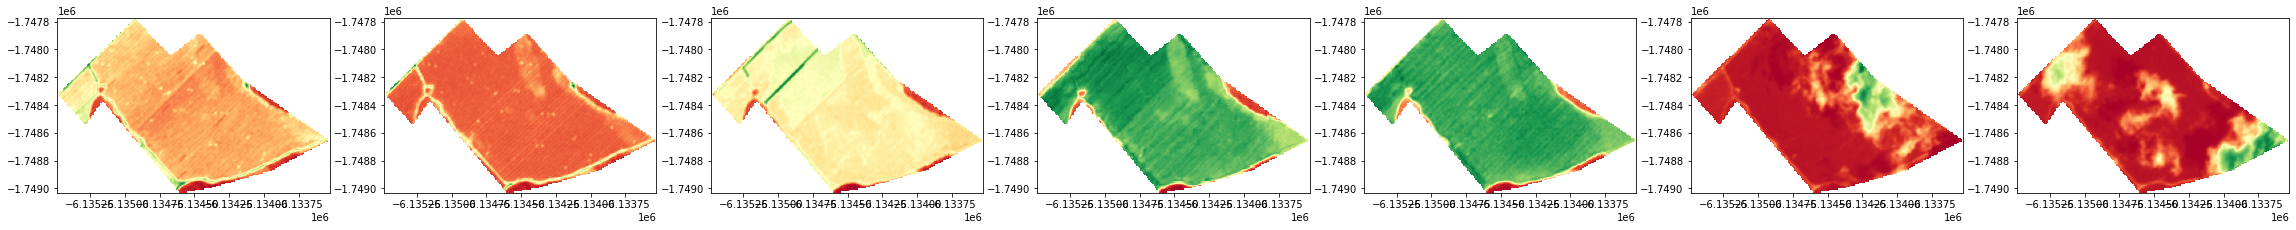

In [20]:

fig, axes = plt.subplots(1, len(rgb_images), figsize=(40,7))
for ax, rgb in zip(axes.flat, rgb_images):
    show(rgb, ax=ax, cmap='RdYlGn')

plt.show()

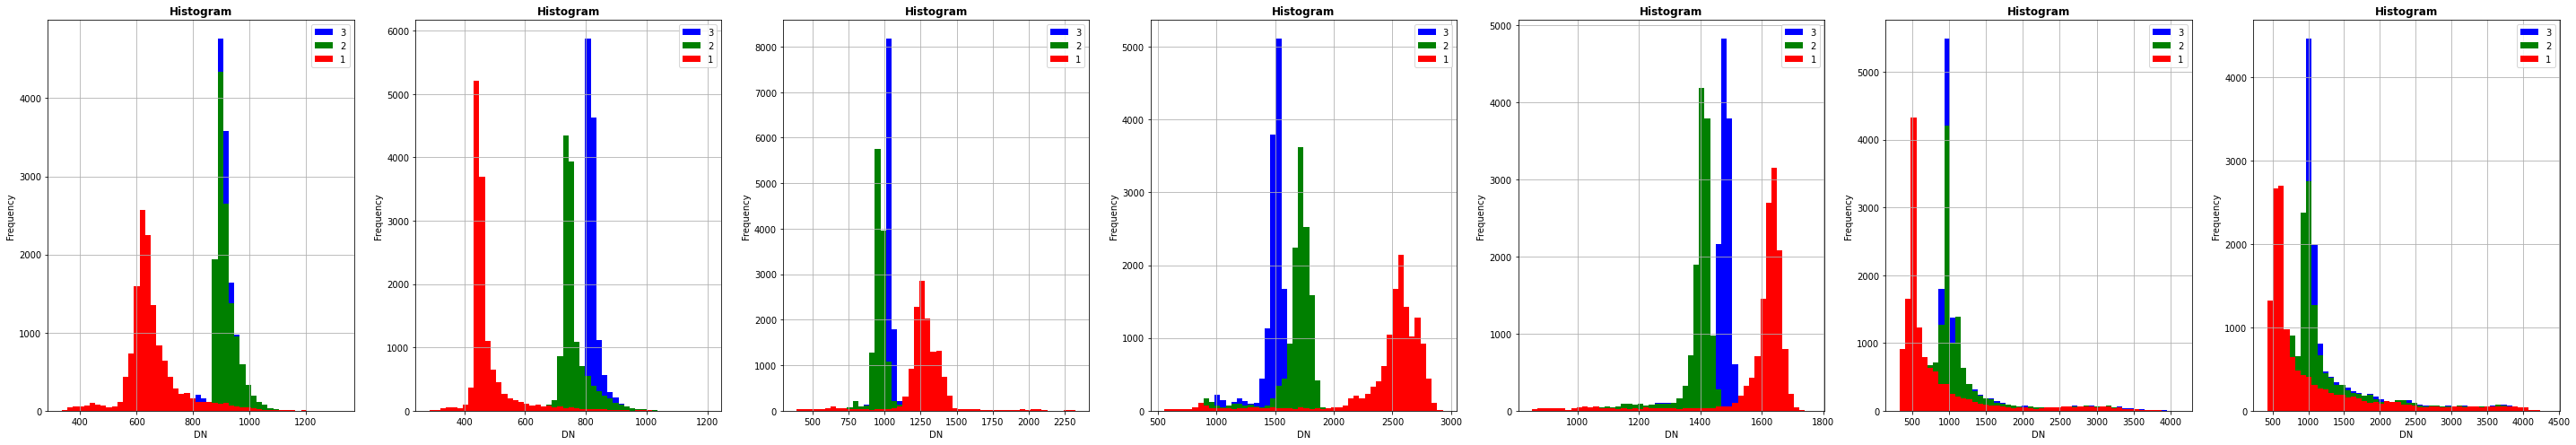

In [21]:

fig, axes = plt.subplots(1, len(rgb_images), figsize=(40,7))
for ax, rgb in zip(axes.flat, rgb_images):
  show_hist(rgb, ax=ax, bins=50, stacked=False, histtype='stepfilled', title="Histogram")

fig.tight_layout()

Nas bandas rgb nos deu mais insumo para entender o que pode ser cada área de mais produtividade, não produtividade ou nuvem (ruído)

## Resumo do que estudamos até então

As explorações dos itens acima nos fez entender que precisavamos separar algumas zonas, a partir dessas zonas extrair seus dados e usá-los como fonte para estudo. O que foi interessante que a exploração foi com base numa amostra.


## Resumo do que terá a seguir

A seguir, o estudo vai avançar para segmentarmos e classificarmos com um algoritmo e com isso obter a média contorno de cada região;
A ideia é após ter a média de cada região, fazer uma média geral e com isso aplicar isso a todas as imagens e entender a evolução das áreas de produtividade pelos pixel

# Insumo para estudo (SEGMENTAÇÃO DE SUPERPIXELS)

Através da exploração das colorações dos NDVIS e seus histogramas, chegamos a um consenso de segmentar os setores das imagens e classifica-los de algumas forma, os estudos indicaram utilizar algoritmos não supervisionados superpixels para segmentar

Algumas tecnicas serão utilizadas através de alguns algoritmos como Slic que utiliza Kmeans e Quickshift que tambem se baseia em aproximação de kernel;


## QuickShift

Quickshift is a relatively recent 2D image segmentation algorithm, based on an approximation of kernelized mean-shift. Therefore it belongs to the family of local mode-seeking algorithms and is applied to the 5D space consisting of color information and image location 2.

One of the benefits of quickshift is that it actually computes a hierarchical segmentation on multiple scales simultaneously.

Quickshift has two main parameters: sigma controls the scale of the local density approximation, max_dist selects a level in the hierarchical segmentation that is produced. There is also a trade-off between distance in color-space and distance in image-space, given by ratio.

2 Quick shift and kernel methods for mode seeking, Vedaldi, A. and Soatto, S. European Conference on Computer Vision, 2008


## Slic

This algorithm simply performs K-means in the 5d space of color information and image location and is therefore closely related to quickshift. As the clustering method is simpler, it is very efficient. It is essential for this algorithm to work in Lab color space to obtain good results. The algorithm quickly gained momentum and is now widely used. See 3 for details. The compactness parameter trades off color-similarity and proximity, as in the case of Quickshift, while n_segments chooses the number of centers for kmeans.





Para as seguintes experimentações estamos utilizando a lib skimage ao invés de rasterio

In [22]:
from skimage.segmentation import quickshift, slic, morphological_geodesic_active_contour, inverse_gaussian_gradient
from skimage import io
from skimage.segmentation import mark_boundaries, find_boundaries
from skimage.filters import sobel
from skimage.color import rgb2gray
from cv2 import cv2
from skimage.measure import regionprops, regionprops_table, moments
from matplotlib.lines import Line2D


Vamos utilizar apenas uma imagem inicialmente para entendimento dos algoritmos e depois disso aplicar no restante.

In [23]:
# Leitura RGB
img = io.imread(dataset_1 + df_1['RGB'][0])
img.shape

(132, 205, 3)

In [24]:
# Leitura NDVI
img_n = io.imread(dataset_1 + df_1['NDVI'][0])
img_n.shape

(132, 205)

In [25]:
# Para utilizar uma imagem NDVI no quickshift preciso criar 3 canais
img2 = np.zeros( ( np.array(img_n).shape[0], np.array(img_n).shape[1], 3 ) )
img2[:,:,0] = img_n
img2[:,:,1] = img_n
img2[:,:,2] = img_n

In [26]:
img2.shape

(132, 205, 3)

# Utilizando algoritmos superpixels 

Abaixo será realizado um teste utilizando alguns algoritmos para entendermos os resultados e compará-los

In [27]:
segments_quickshift = quickshift(img2)
print("Quickshift número de segmentos: %d" % len(np.unique(segments_quickshift)))

Quickshift número de segmentos: 20


In [28]:
segments_slic = slic(img2, n_segments=21, compactness=0.9, sigma=0.2,
                     start_label=1)
print("Slic número de segmentos: %d" % len(np.unique(segments_slic)))
print("Size: ", segments_slic.size)

Slic número de segmentos: 12
Size:  27060


In [29]:
gradient = sobel(rgb2gray(img2))
print("Gradient número de segmentos: %d" % len(np.unique(gradient)))

Gradient número de segmentos: 14143


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Gradient')

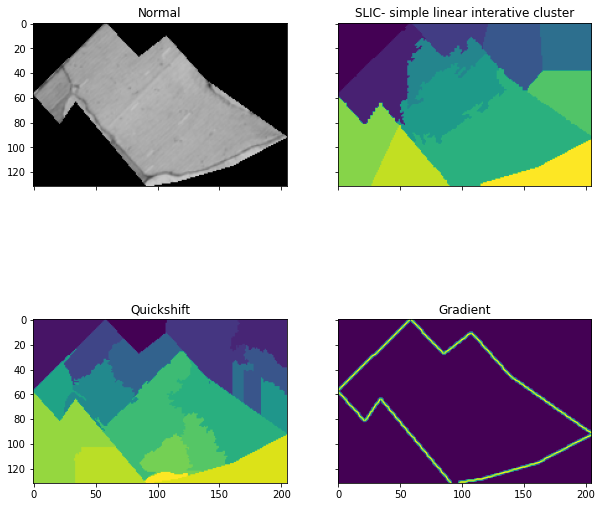

In [30]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
ax[0, 0].imshow(img2)
ax[0, 0].set_title("Normal")
ax[0, 1].imshow(segments_slic)
ax[0, 1].set_title('SLIC- simple linear interative cluster')
ax[1, 0].imshow(segments_quickshift)
ax[1, 0].set_title('Quickshift')
ax[1, 1].imshow(gradient)
ax[1, 1].set_title('Gradient')

Observando os resultados obtidos, vamos seguir com a segmentação quickshift, pois ele de forma automática consegue nos dizer o kernel, é similar ao mean shift e consegue classificar os clusters dos pixels por suas cores e junção dos dados espaciais.


NDVI deu um resultado de segmentação próximo ao RGB, buscando o motivo entendemos que é pq o quickshift acaba trabalhando com o canal rgb.

Até este momento utilizamos o site https://scikit-image.org/ para insumo dos estudos

# Estudo de contornos

Conseguimos até então segmentar, porém o contorno é útil pois precisamos entender como extrair a média dos mesmo com base em foruns de entendimento de evolução de uma imagem de satélite.

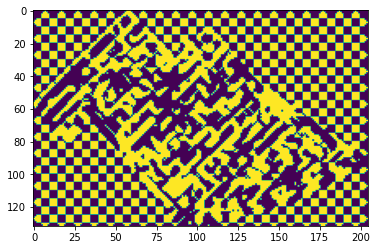

In [31]:
# Estudo de contornos
morph_test = morphological_geodesic_active_contour(img_n, 2, 'checkerboard')
plt.imshow(morph_test)

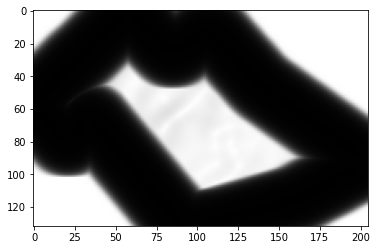

In [32]:
# Estudo de contornos
ig = inverse_gaussian_gradient(img2)
plt.imshow(ig)

# Criação de datasets 

Abaixo estudando a biblioteca scikit image, entendemos como criar um novo dataset com os dados detalhados da imagem.

In [33]:
# Acessando cada um dos segmentos
# https://scikit-image.org/docs/dev/api/skimage.measure.html

props = pd.DataFrame(regionprops_table(segments_quickshift, img2))
props

label  bbox-0  bbox-1  bbox-2  bbox-3
0       1       0       0      57      58
1       2       0     159      39     205
2       3       0     107      61     174
3       4       0      24      53      73
4       5      21     170      77     205
5       6      11      60      63     121
6       7      33     161      67     178
7       8      50     142      52     143
8       9      32      25      90      85
9      10      47     184      92     205
10     11      24       0      82      43
11     12      32     108     117     205
12     13      26      50     130     128
13     14      75     119     123     157
14     15      92      86     127     136
15     16      59       0     132      67
16     17     103      33     132      91
17     18      93      98     132     205
18     19     123      90     132     125

In [34]:
# labels das áreas da
segments_ids = np.unique(segments_quickshift)
segments_ids

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [35]:
# pontos centrais da imagem
centers = np.array([np.mean(np.nonzero(segments_quickshift==i),axis=1) for i in segments_ids])


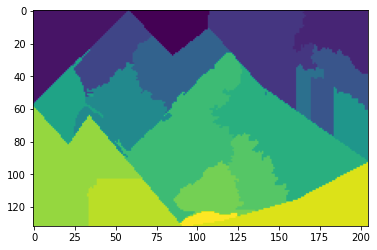

In [36]:
plt.imshow(segments_quickshift)

# Classificação de pixels

Abaixo conseguimos entender como a partir de um NDVI separar e classificar suas áreas. O algoritmo de superpixel nos ajudou nessa segmentação e conseguimos com uma imagem já dizer se é uma zona produtiva ou não.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


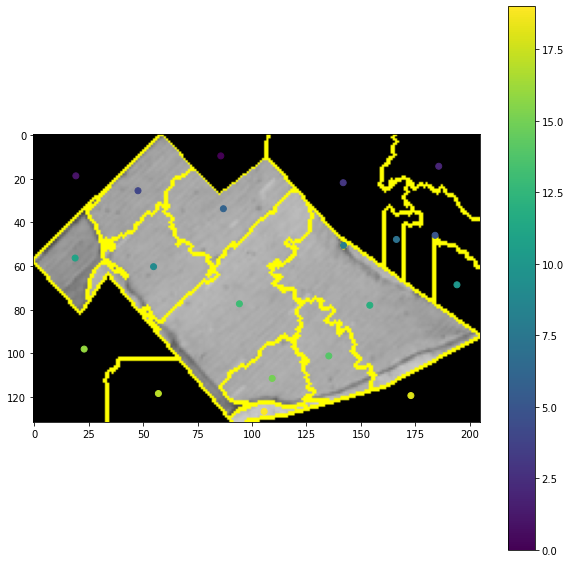

In [37]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.imshow(mark_boundaries(img2, segments_quickshift))
plt.scatter(centers[:,1],centers[:,0], c=segments_ids)

cb = plt.colorbar()


Entendendo que o algoritmo usa os vizinhos para buscar classificar, estamos a seguir realizando um check para saber como os vizinhos se encontram

In [38]:
# Criação de variáveis para entender quem é o vizinho de quem

right = np.vstack([segments_quickshift[:,:-1].ravel(), segments_quickshift[:,1:].ravel()])
below = np.vstack([segments_quickshift[:-1,:].ravel(), segments_quickshift[1:,:].ravel()])
neighbors = np.unique(np.hstack([right, below]), axis=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


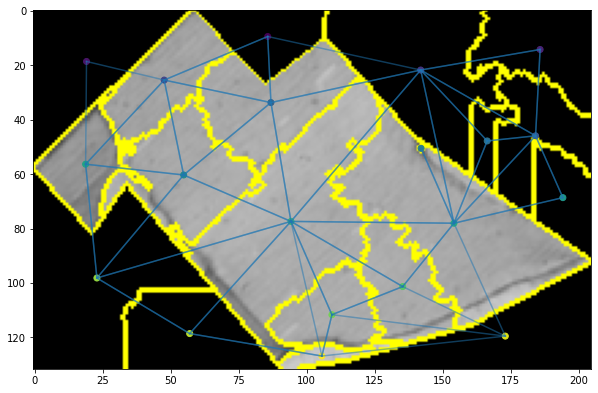

In [39]:
# Como são conectados os Pontos?

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.imshow(mark_boundaries(img2, segments_quickshift))
plt.scatter(centers[:,1],centers[:,0], c=segments_ids)


for i in range(neighbors.shape[1]):
    y0,x0 = centers[neighbors[0,i]]
    y1,x1 = centers[neighbors[1,i]]

    l = Line2D([x0,x1],[y0,y1], alpha=0.5)
    ax.add_line(l)

A detecção do contorno permite definir propriedades como
perímetro e forma do objeto em uma representação concisa,
mas não é de simples determinação, devido a grande variação
de condições de iluminação das imagens reais;




# Solução para entender áreas produtivas ou não produtivas

- criar loop para coordenadas X e Y [x, y] e investigar média de itensidade de pixels a partir de um contorno, e assim tentar entender o que é produtivo, improdutivo e nuvem

In [40]:
def mean_pixels(regionmask, intensity):
     return np.mean(intensity[regionmask])
# Algumas propriedades extras foram colocadas no dataframe, assim como a média do contorno de itensidade de pixels

props_df = pd.DataFrame(regionprops_table(segments_quickshift, img2, properties=['label', 'centroid', 'orientation', 'bbox', 'coords', 'solidity'], extra_properties=(mean_pixels,)))
props_df

label  centroid-0  centroid-1  orientation  bbox-0  bbox-1  bbox-2  \
0       1   18.586207   19.086207    -0.811262       0       0      57   
1       2   14.187663  185.729800     1.264091       0     159      39   
2       3   21.736142  141.860754     0.841750       0     107      61   
3       4   25.419833   47.623726    -0.742629       0      24      53   
4       5   45.900000  184.056075    -0.232685      21     170      77   
5       6   33.683246   86.839660    -1.197282      11      60      63   
6       7   47.790850  166.300654    -0.135282      33     161      67   
7       8   50.500000  142.000000     0.000000      50     142      52   
8       9   60.290510   54.771465     1.434937      32      25      90   
9      10   68.615385  194.096531     0.319421      47     184      92   
10     11   56.327869   18.757611    -0.233628      24       0      82   
11     12   78.018030  154.080489     0.919923      32     108     117   
12     13   77.350905   94.195571    -0.543040      26      50     130   
13     14  101.287923  135.250242     0.435413      75     119     123   
14     15  111.624009  109.245753    -1.444082      92      86     127   
15     16   98.140819   22.900512    -0.480441      59       0     132   
16     17  118.557543   56.990669     1.385772     103      33     132   
17     18  119.490231  172.943754    -1.342137      93      98     132   
18     19  126.805714  105.554286    -1.439653     123      90     132   

    bbox-3                                             coords  solidity  \
0       58  [[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...  0.991745   
1      205  [[0, 166], [0, 167], [0, 168], [0, 169], [0, 1...  0.800974   
2      174  [[0, 108], [0, 109], [0, 110], [0, 111], [0, 1...  0.868310   
3       73  [[0, 58], [1, 57], [1, 58], [1, 59], [2, 56], ...  0.872272   
4      205  [[21, 172], [22, 172], [22, 173], [23, 172], [...  0.706737   
5      121  [[11, 107], [12, 105], [12, 106], [12, 107], [...  0.794592   
6      178  [[33, 163], [34, 162], [34, 163], [34, 164], [...  0.709977   
7      143                             [[50, 142], [51, 142]]  1.000000   
8       85  [[32, 57], [32, 58], [33, 57], [33, 58], [33, ...  0.728598   
9      205  [[47, 184], [48, 184], [48, 185], [49, 184], [...  0.960870   
10      43  [[24, 34], [25, 33], [26, 32], [27, 31], [28, ...  0.634944   
11     205  [[32, 126], [33, 127], [34, 127], [34, 128], [...  0.798252   
12     128  [[26, 118], [26, 119], [26, 120], [26, 121], [...  0.728636   
13     157  [[75, 129], [76, 125], [76, 126], [76, 128], [...  0.818182   
14     136  [[92, 115], [93, 113], [93, 114], [93, 115], [...  0.783496   
15      67  [[59, 0], [60, 0], [60, 1], [61, 0], [61, 1], ...  0.774285   
16      91  [[103, 39], [103, 40], [103, 41], [103, 42], [...  0.977947   
17     205  [[93, 204], [94, 202], [94, 203], [94, 204], [...  0.789252   
18     125  [[123, 103], [123, 104], [123, 105], [123, 106...  0.853659   

    mean_pixels  
0  -9999.000000  
1  -9999.000000  
2  -9999.000000  
3      0.626725  
4  -9999.000000  
5      0.665651  
6  -9999.000000  
7      0.220272  
8      0.659710  
9  -9999.000000  
10     0.534212  
11     0.653159  
12     0.668267  
13     0.664985  
14     0.662740  
15 -9999.000000  
16 -9999.000000  
17 -9999.000000  
18     0.761869

Removendo ruído, áreas externas do dataset

In [41]:
props_df = props_df.query('mean_pixels >= 0')

In [42]:
props_df

label  centroid-0  centroid-1  orientation  bbox-0  bbox-1  bbox-2  \
3       4   25.419833   47.623726    -0.742629       0      24      53   
5       6   33.683246   86.839660    -1.197282      11      60      63   
7       8   50.500000  142.000000     0.000000      50     142      52   
8       9   60.290510   54.771465     1.434937      32      25      90   
10     11   56.327869   18.757611    -0.233628      24       0      82   
11     12   78.018030  154.080489     0.919923      32     108     117   
12     13   77.350905   94.195571    -0.543040      26      50     130   
13     14  101.287923  135.250242     0.435413      75     119     123   
14     15  111.624009  109.245753    -1.444082      92      86     127   
18     19  126.805714  105.554286    -1.439653     123      90     132   

    bbox-3                                             coords  solidity  \
3       73  [[0, 58], [1, 57], [1, 58], [1, 59], [2, 56], ...  0.872272   
5      121  [[11, 107], [12, 105], [12, 106], [12, 107], [...  0.794592   
7      143                             [[50, 142], [51, 142]]  1.000000   
8       85  [[32, 57], [32, 58], [33, 57], [33, 58], [33, ...  0.728598   
10      43  [[24, 34], [25, 33], [26, 32], [27, 31], [28, ...  0.634944   
11     205  [[32, 126], [33, 127], [34, 127], [34, 128], [...  0.798252   
12     128  [[26, 118], [26, 119], [26, 120], [26, 121], [...  0.728636   
13     157  [[75, 129], [76, 125], [76, 126], [76, 128], [...  0.818182   
14     136  [[92, 115], [93, 113], [93, 114], [93, 115], [...  0.783496   
18     125  [[123, 103], [123, 104], [123, 105], [123, 106...  0.853659   

    mean_pixels  
3      0.626725  
5      0.665651  
7      0.220272  
8      0.659710  
10     0.534212  
11     0.653159  
12     0.668267  
13     0.664985  
14     0.662740  
18     0.761869

Vamos extrair uma média geral dessa área

In [43]:
props_df.mean_pixels.mean()

0.6117589362593769

Avaliando que nosso critério será que acima de 50% é uma zona produtiva.


Os critério que levamos em consideração é menor de 50% lavoura improdutiva, maior que 50% lavoura produtiva, se o mesmo tiver acima de 70% tende a ser uma área adiantada, menor que 30% atrasada

# Aplicando a todas as imagens

In [44]:
len(df_1['NDVI'])

66

In [59]:
data = {
    'image_label': [],
    'mean_itensity_border_pixels': []
}

In [60]:
# Leitura NDVI
for i in range(len(df_1['NDVI'])):
  try:
    img_ndvi = io.imread(dataset_1 + df_1['NDVI'][i])

    img_n_3_bands = np.zeros( ( np.array(img_ndvi).shape[0], np.array(img_ndvi).shape[1], 3 ) )
    img_n_3_bands[:,:,0] = img_ndvi
    img_n_3_bands[:,:,1] = img_ndvi
    img_n_3_bands[:,:,2] = img_ndvi

    segments_quickshift = quickshift(img_n_3_bands)

    props_df = pd.DataFrame(regionprops_table(segments_quickshift, img_n_3_bands, properties=['label', 'centroid', 'orientation', 'bbox', 'coords', 'solidity'], extra_properties=(mean_pixels,)))

    props_df = props_df.query('mean_pixels >= 0')

    _mean = props_df.mean_pixels.mean()
    label = df_1['NDVI'][i].split('.')[0].split('NDVI/')[1]
    print(label, _mean)

    data['image_label'].append(_mean)
    data['mean_itensity_border_pixels'].append(label)

  except:
    print('Não encontrado', df_1['NDVI'][i])
    continue

2016-03-30 0.6117589362593769
2016-04-29 0.7353234963474953
2016-07-18 0.2997281157351788
2016-08-07 0.2514549452990232
2016-09-16 0.21207136483340427
2016-11-25 0.5630586473079519
2016-12-05 0.6216042225557235
2017-01-04 0.41683086817314147
2017-02-23 0.320157717425291
2017-04-04 0.4811207493654067
2017-05-14 0.6380545410451968
2017-06-03 0.6373823287969835
2017-07-13 0.4155503328225993
2017-08-17 0.30370630179737285
2017-09-11 0.28441811110140125
2017-10-16 0.2579129994666307
2017-11-15 0.5190961879036646
2017-12-20 0.6440211537669492
2018-01-24 0.2938728171905592
2018-02-18 0.3409877839347024
Não encontrado NDVI/2018-03-20.tif
2018-04-14 0.7225349650647033
2018-05-14 0.7078097405810512
2018-06-18 0.6066970224568726
2018-07-18 0.4533985102128665
2018-08-17 0.326708849367157
2018-09-21 0.1937926474389709
2018-10-26 0.5605552144847848
2018-11-15 0.4286369058978435
2018-12-25 0.37000842116555965
2019-01-24 0.30947697682173264
2019-02-03 0.42964461624028116
2019-03-10 0.5257937950253023


In [61]:

new_image_analyses_mean_pixels = pd.DataFrame(data)

In [62]:
new_image_analyses_mean_pixels.head()

image_label mean_itensity_border_pixels
0     0.611759                  2016-03-30
1     0.735323                  2016-04-29
2     0.299728                  2016-07-18
3     0.251455                  2016-08-07
4     0.212071                  2016-09-16

In [64]:
import seaborn as sns

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64],
 <a list of 65 Text major ticklabel objects>)

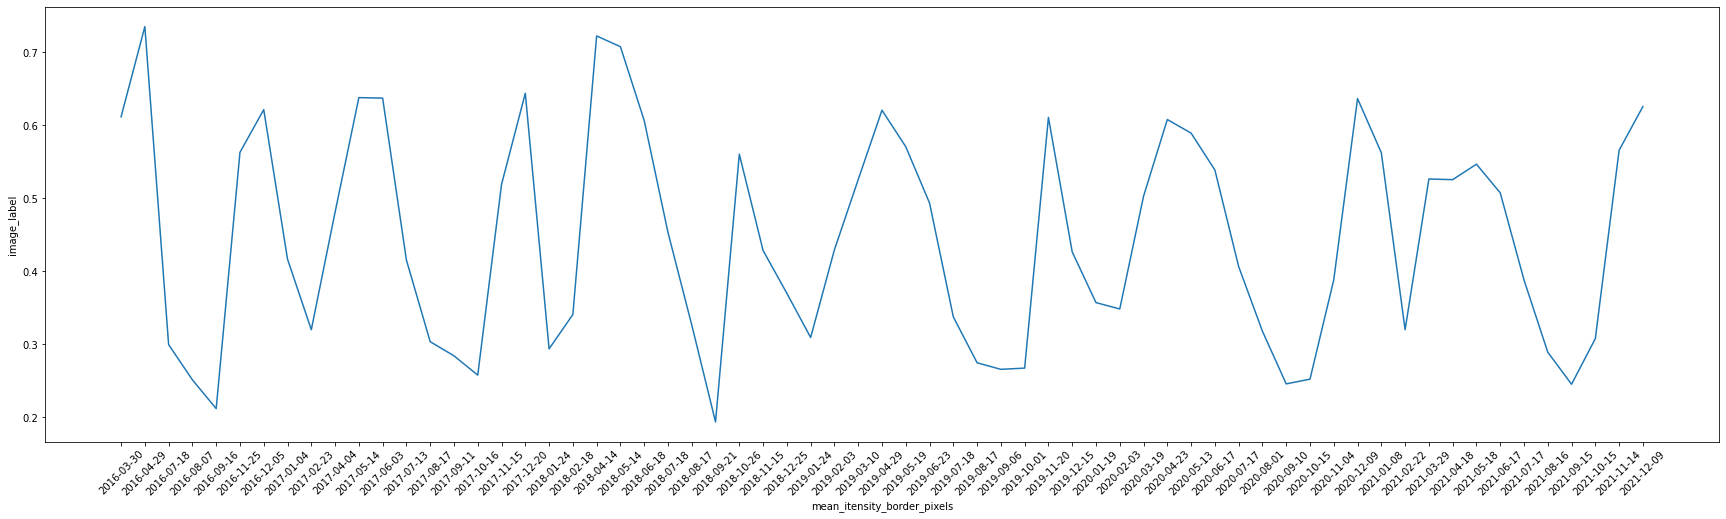

In [72]:
ax = sns.lineplot(y=new_image_analyses_mean_pixels.image_label, x=new_image_analyses_mean_pixels.mean_itensity_border_pixels)
ax.figure.set_size_inches(30, 8)
plt.xticks(rotation=45)

Entendemos aqui como é a produtividade e improdutividade de cada uma das imagens analisadas.




In [73]:
data2 = {
    'image_label': [],
    'mean_itensity_border_pixels': []
}

In [74]:
# Leitura NDVI
for i in range(len(df_2['NDVI'])):
  try:
    img_ndvi = io.imread(dataset_1 + df_2['NDVI'][i])

    img_n_3_bands = np.zeros( ( np.array(img_ndvi).shape[0], np.array(img_ndvi).shape[1], 3 ) )
    img_n_3_bands[:,:,0] = img_ndvi
    img_n_3_bands[:,:,1] = img_ndvi
    img_n_3_bands[:,:,2] = img_ndvi

    segments_quickshift = quickshift(img_n_3_bands)

    props_df = pd.DataFrame(regionprops_table(segments_quickshift, img_n_3_bands, properties=['label', 'centroid', 'orientation', 'bbox', 'coords', 'solidity'], extra_properties=(mean_pixels,)))

    props_df = props_df.query('mean_pixels >= 0')

    _mean = props_df.mean_pixels.mean()
    label = df_2['NDVI'][i].split('.')[0].split('NDVI/')[1]
    print(label, _mean)

    data2['image_label'].append(_mean)
    data2['mean_itensity_border_pixels'].append(label)

  except:
    print('Não encontrado', df_2['NDVI'][i])
    continue

2016-03-30 0.6117589362593769
2016-04-29 0.7353234963474953
Não encontrado NDVI/2016-05-19.tif
Não encontrado NDVI/2016-06-28.tif
2016-07-18 0.2997281157351788
2016-08-07 0.2514549452990232
2016-09-16 0.21207136483340427
Não encontrado NDVI/2016-10-26.tif
2016-12-05 0.6216042225557235
2017-01-04 0.41683086817314147
2017-02-23 0.320157717425291
2017-04-04 0.4811207493654067
2017-05-14 0.6380545410451968
2017-06-03 0.6373823287969835
2017-07-13 0.4155503328225993
2017-08-17 0.30370630179737285
2017-09-11 0.28441811110140125
2017-10-16 0.2579129994666307
2017-11-15 0.5190961879036646
2017-12-20 0.6440211537669492
2018-01-24 0.2938728171905592
Não encontrado NDVI/2018-02-28.tif
Não encontrado NDVI/2018-03-30.tif
Não encontrado NDVI/2018-04-24.tif
Não encontrado NDVI/2018-05-24.tif
Não encontrado NDVI/2018-06-13.tif
2018-07-18 0.4533985102128665
2018-08-17 0.326708849367157
Não encontrado NDVI/2018-09-11.tif
Não encontrado NDVI/2018-10-16.tif
Não encontrado NDVI/2018-11-10.tif
Não encontrad

In [75]:

new_image_analyses_mean_pixels2 = pd.DataFrame(data2)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39],
 <a list of 40 Text major ticklabel objects>)

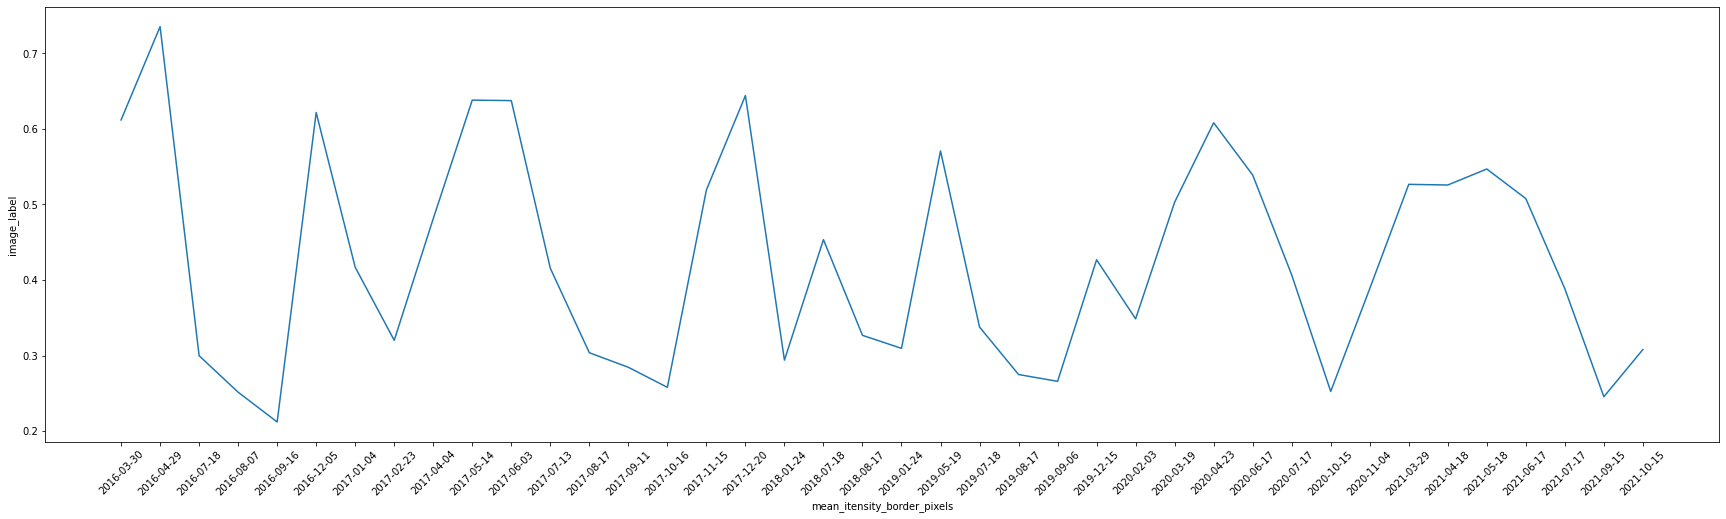

In [76]:
ax = sns.lineplot(y=new_image_analyses_mean_pixels2.image_label, x=new_image_analyses_mean_pixels2.mean_itensity_border_pixels)
ax.figure.set_size_inches(30, 8)
plt.xticks(rotation=45)